In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import pandas as pd

Global seed set to 0


# Read data

In [2]:
adata = sc.read('../../hindbrain_pons/OligoPons_metafromSten.loom')

In [3]:
embedding= pd.read_csv('../../hindbrain_pons/embedding.csv', sep=',', index_col=0)
annotations = pd.read_csv('../../hindbrain_pons/annotations.csv', sep=',', index_col=0)

adata.obs['index'] = adata.obs['Sample_Index'].index.values
adata = adata[adata.obs['index'].isin(embedding.index.values)]
annotation_cats = pd.Categorical(annotations.values.flatten().astype(str))
annotations_cats_fixed = annotation_cats.rename_categories({'2': 'NFOLS', '3': 'MFOLS', '6':'COPs'})
adata.obs['annotation'] = annotations_cats_fixed
adata.obsm['X_tsne']= embedding.values

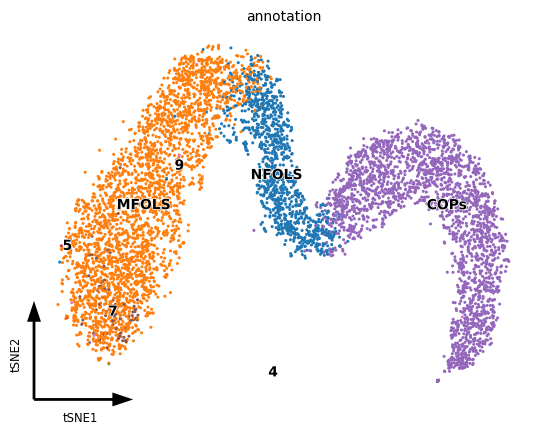

In [4]:
scv.pl.tsne(adata, color='annotation', frameon='artist')

# Setup data and train model

In [5]:
scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.anvi_clean_recipe(adata, celltype_key='annotation')

Filtered out 22484 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
model = ltv.models.AnnotVAE(observed=2000, latent_dim=20, zr_dim=1, h_dim=2,
                      celltypes = len(adata.obs.annotation.unique()))

In [7]:
epochs, val_ae, val_traj = ltv.train_anvi(model, adata, batch_size = 1000,
                                      epochs=50, name='hindbrain_parameters', grad_clip=10000)

Warning, folder already exists. This may overwrite a previous fit.
608 velocity genes used
epoch 0, full loss 182.835, val loss 171.628, ae MSE 3.268, traj MSE 1.407, reg loss -2.186
epoch 1, full loss 180.185, val loss 119.975, ae MSE 1.250, traj MSE 1.069, reg loss -2.411
epoch 2, full loss 119.336, val loss 107.110, ae MSE 1.198, traj MSE 0.727, reg loss -2.638
epoch 3, full loss 101.551, val loss 92.940, ae MSE 0.832, traj MSE 0.638, reg loss -2.893
epoch 4, full loss 84.733, val loss 81.457, ae MSE 0.798, traj MSE 0.595, reg loss -3.038
epoch 5, full loss 70.724, val loss 68.004, ae MSE 0.762, traj MSE 0.579, reg loss -3.155
epoch 6, full loss 58.675, val loss 55.473, ae MSE 0.713, traj MSE 0.571, reg loss -3.269
epoch 7, full loss 44.992, val loss 44.612, ae MSE 0.809, traj MSE 0.570, reg loss -3.414
epoch 8, full loss 31.346, val loss 32.109, ae MSE 0.745, traj MSE 0.567, reg loss -3.523
epoch 9, full loss 24.378, val loss 19.504, ae MSE 0.681, traj MSE 0.567, reg loss -3.623
ep

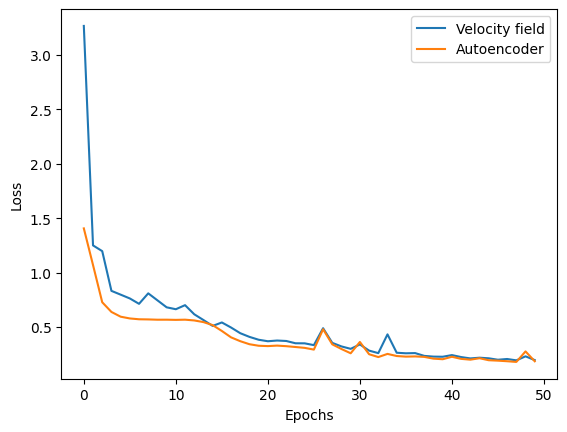

In [8]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute and plot velocity on tSNE

In [10]:
latent_adata = ltv.output_results(model, adata, embedding='tsne')

In [11]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/6253 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


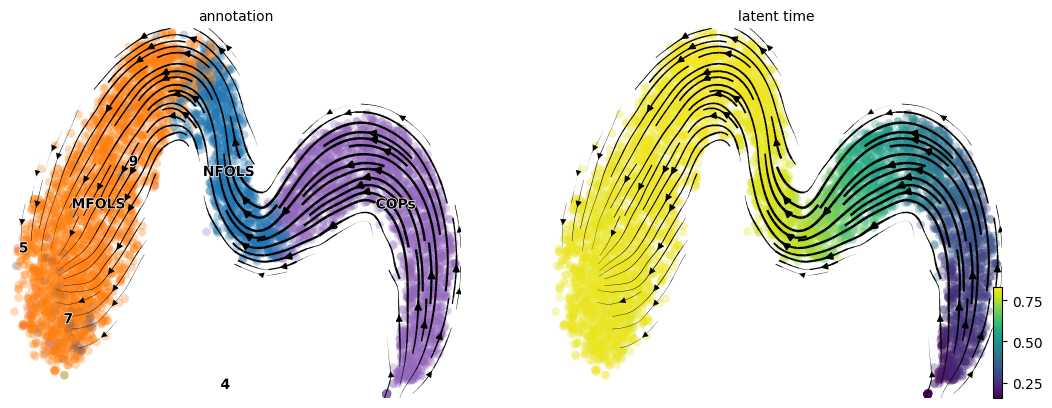

In [12]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity',
                                color=['annotation', 'latent_time'])

In [14]:
# save fit
latent_adata.write('../benchmark/real_data/fits/hindbrain_latent_adata.h5ad')

# Compute CBDir transition scores

In [12]:
hindbrain_edges = [
        ('COPs', 'NFOLS'), 
        ('NFOLS', 'MFOLS')]

In [13]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
hindbrain_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'annotation', 'spliced_velocity_pca', hindbrain_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


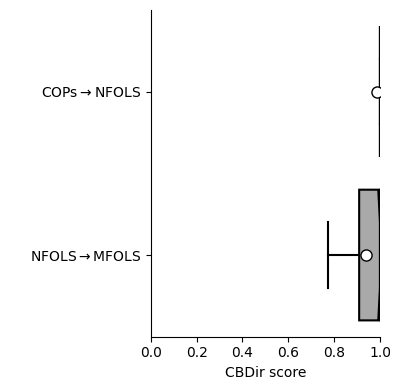

In [14]:
ax=ltv.pl.transition_scores(hindbrain_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()